In [1]:
import utils
from batchgen import BatchGenerator
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
import json
from os.path import join
import pickle
from PIL import Image
import scipy.ndimage as ndimage
import cv2
from tqdm import tqdm

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Activation, Convolution2D, Dropout, Conv2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import Multiply, Average
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers

In [3]:
# load data
dt = utils.DirectoryTree("data/Category and Attribute Prediction Benchmark/")
with open(join(dt.Anno.path, 'meta.pickle'), 'rb' ) as f:
    data = pickle.load(f)

In [4]:
gen_train = BatchGenerator(image_paths = list(map(lambda path: join(dt.Img.path, path), data['img_names'])), 
                           bboxes = data['bbox_coords'],
                           categories=data['cat_labels'],
                           attributes=data['attr_labels'],
                           eval_status=data['eval_status'],
                           batch_size=8,
                           image_size=(256, 256),
                           activation_map_size=(32, 32),
                           activation_map_mode='gaussian',
                           mode = 'train')

In [5]:
X, [Y_map, Y_cat, Y_attr] = gen_train.__getitem__(100) 

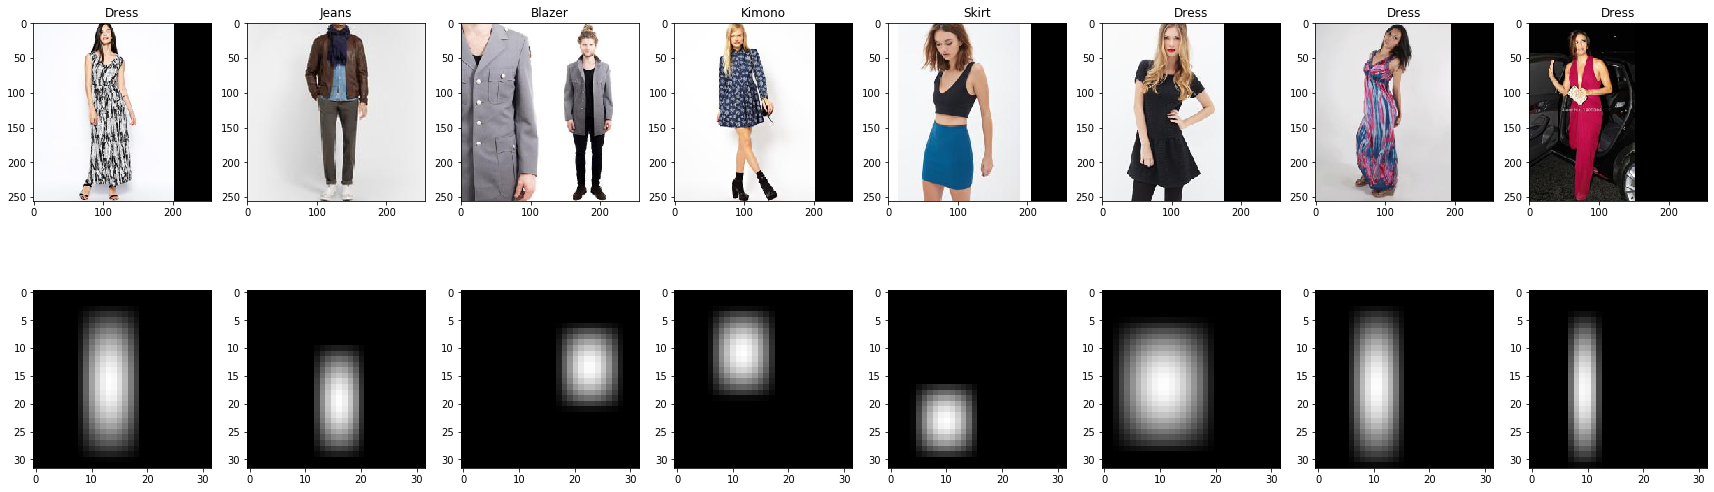

In [6]:
fig, axes = plt.subplots(2, 8, figsize = (30, 9))
for i, (img, act_map, cat) in enumerate(zip(X[:8], Y_map[:8], Y_cat[:8])):
    axes[0, i].imshow(img)
    act_map = np.expand_dims(act_map, axis = -1)
    axes[1, i].imshow(np.concatenate([act_map, act_map, act_map], axis = -1))
    # axes[1, i].imshow(act_map)
    axes[0, i].set_title("%s"%data['cat_index'][str(np.argmax(cat))])
plt.show()

In [5]:
gen_train = BatchGenerator(image_paths = list(map(lambda path: join(dt.Img.path, path), data['img_names'])), 
                           bboxes = data['bbox_coords'],
                           categories=data['cat_labels'],
                           attributes=data['attr_labels'],
                           eval_status=data['eval_status'],
                           batch_size=8,
                           image_size=(256, 256),
                           return_activation_map=False,
                           activation_map_size=(32, 32),
                           activation_map_mode='gaussian',
                           mode = 'test')

In [6]:
X, [Y_cat, Y_attr] = gen_train.__getitem__(100) 

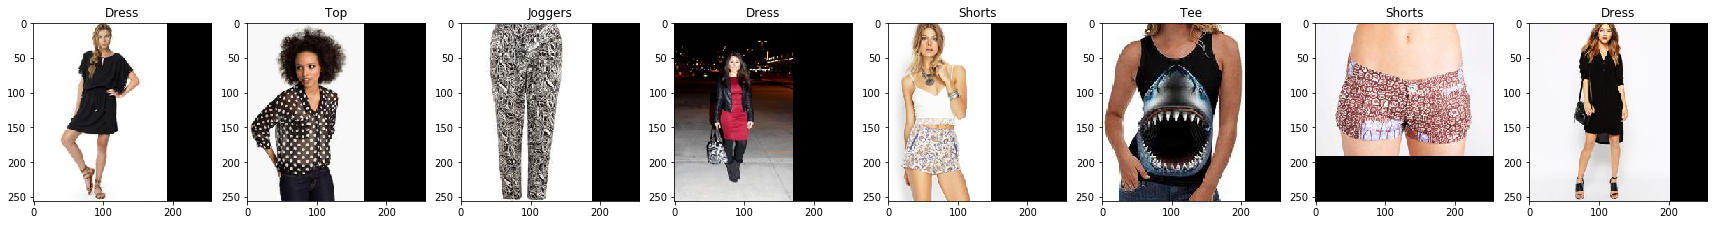

In [11]:
fig, axes = plt.subplots(1, 8, figsize = (30, 9))
for i, (img, cat) in enumerate(zip(X[:8], Y_cat[:8])):
    axes[i].imshow(img)
    # act_map = np.expand_dims(act_map, axis = -1)
    # axes[1, i].imshow(np.concatenate([act_map, act_map, act_map], axis = -1))
    # axes[1, i].imshow(act_map)
    axes[i].set_title("%s"%data['cat_index'][str(np.argmax(cat))])
plt.show()

In [9]:
input_shape = [256, 256, 3]

In [10]:
gen_train = BatchGenerator(image_paths = list(map(lambda path: join(dt.Img.path, path), data['img_names'])), 
                           bboxes = data['bbox_coords'],
                           categories=data['cat_labels'],
                           attributes=data['attr_labels'],
                           eval_status=data['eval_status'],
                           batch_size=64,
                           image_size=input_shape[:2],
                           activation_map_size=(32, 32),
                           activation_map_mode='gaussian',
                           mode = 'train')

gen_val = BatchGenerator(image_paths = list(map(lambda path: join(dt.Img.path, path), data['img_names'])), 
                           bboxes = data['bbox_coords'],
                           categories=data['cat_labels'],
                           attributes=data['attr_labels'],
                           eval_status=data['eval_status'],
                           batch_size=64,
                           image_size=input_shape[:2],
                           activation_map_size=(32, 32),
                           activation_map_mode='gaussian',
                           mode = 'val')
print("Number of batches in training data:", len(gen_train))
print("Number of batches in validtaion data:", len(gen_val))

Number of batches in training data: 3269
Number of batches in validtaion data: 625


In [11]:
def bigxception(input_shape = (256, 256, 3)):
    regularization = l2(0.01)
    input_tensor = Input(input_shape)
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(input_tensor)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False)(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)
    map_out = K.mean(x, axis = -1)
    cat_x = SeparableConv2D(50, (32, 32), strides = (1, 1), activation = 'softmax')(x)
    cat_out = Flatten(name = 'categories')(cat_x)
    attr_x = SeparableConv2D(1000, (32, 32), strides = (1, 1), activation = 'sigmoid')(x)
    attr_out = Flatten(name = 'attributes')(attr_x)
    return keras.models.Model(inputs = input_tensor, outputs = [map_out, cat_out, attr_out])

In [12]:
model = bigxception(input_shape=input_shape)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [14]:
model.compile(optimizer = 'adam', 
              loss = {'tf_op_layer_Mean':'mse', 'categories':'categorical_crossentropy', 'attributes':'binary_crossentropy'},
              metrics = {'categories':'categorical_accuracy', 'attributes':'binary_accuracy'})

In [ ]:
model.fit_generator(gen_train, 
                    validation_data=gen_val, 
                    epochs = 100,
                    verbose = 1, 
                    use_multiprocessing = True,
                    workers = 8)

Epoch 1/100
3269/3269 [==============================] - 2452s 750ms/step - loss: 1.6509 - tf_op_layer_Mean_loss: 0.0541 - categories_loss: 1.5802 - attributes_loss: 0.0166 - categories_categorical_accuracy: 0.5347 - attributes_binary_accuracy: 0.9967 - val_loss: 1.7403 - val_tf_op_layer_Mean_loss: 0.0537 - val_categories_loss: 1.6699 - val_attributes_loss: 0.0168 - val_categories_categorical_accuracy: 0.5188 - val_attributes_binary_accuracy: 0.9967
Epoch 2/100
3269/3269 [==============================] - 2453s 751ms/step - loss: 1.5119 - tf_op_layer_Mean_loss: 0.0525 - categories_loss: 1.4431 - attributes_loss: 0.0163 - categories_categorical_accuracy: 0.5712 - attributes_binary_accuracy: 0.9967 - val_loss: 1.6725 - val_tf_op_layer_Mean_loss: 0.0534 - val_categories_loss: 1.6024 - val_attributes_loss: 0.0168 - val_categories_categorical_accuracy: 0.5363 - val_attributes_binary_accuracy: 0.9967
Epoch 3/100
3269/3269 [==============================] - 2459s 752ms/step - loss: 1.3876 - t

In [17]:
model.save('progress/act_cat_attr_model_2.hdf5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

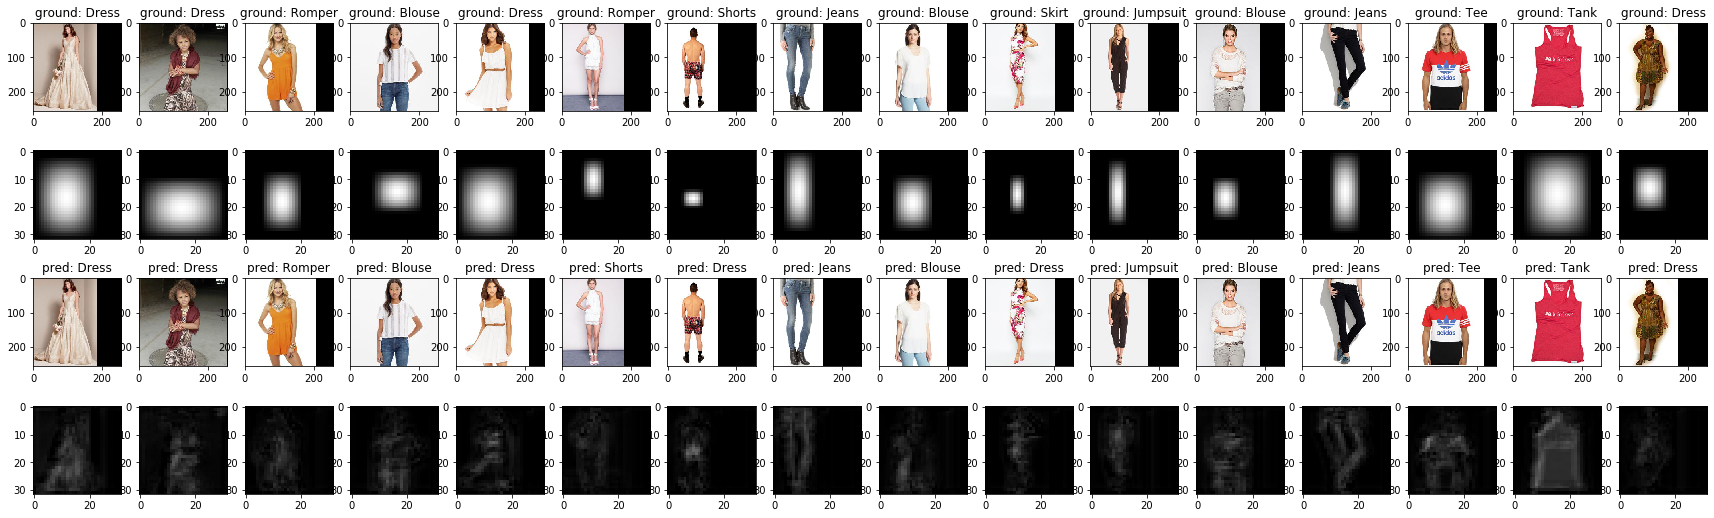

In [19]:
# Predict 16 images from the test batch and visualize results
N = 16
X, [Y_map, Y_cat, Y_attr] = gen_val.__getitem__(100)
pred_map, pred_cat, pred_attr = model.predict(X[:N].astype(np.float32))
fig, axes = plt.subplots(4, N, figsize = (30, 9))
for i, (img, pred_act_map, pred_cat, act_map, cat) in enumerate(zip(X[:N], pred_map[:N], pred_cat[:N], Y_map[:N], Y_cat[:N])):
    axes[0, i].imshow(img)
    axes[0, i].set_title("ground: %s"%data['cat_index'][str(np.argmax(cat))])
    act_map = np.expand_dims(act_map, axis = -1)
    axes[1, i].imshow(np.concatenate([act_map, act_map, act_map], axis = -1))
    axes[2, i].imshow(img)
    axes[2, i].set_title("pred: %s"%data['cat_index'][str(np.argmax(pred_cat))])
    pred_act_map = np.expand_dims(pred_act_map, axis = -1)
    axes[3, i].imshow(np.concatenate([pred_act_map, pred_act_map, pred_act_map], axis = -1))
plt.show()